In [133]:
import numpy as np
from matplotlib import pyplot as pl
import pandas as pd
from IPython.display import display
from typing import NamedTuple
import json
import datetime

In [139]:
pkgs = pd.DataFrame(json.load(open('packages.json')))
pkgs['releaseDate'] = pd.to_datetime(pkgs['releaseDate'], utc=True)
pkgs['extensionPragmas'] = pkgs['extensionPragmas'].apply(set)
pkgs['defaultExtensions'] = pkgs['defaultExtensions'].apply(set)

pkgs

,defaultExtensions,extensionPragmas,name,releaseDate,version
0,{},"{DefaultSignatures, BangPatterns, TypeFamilies...",text-lips,2022-09-17 15:35:56+00:00,0.1.0.2
1,{},"{TypeFamilies, UndecidableInstances, DeriveFun...",reflex-dom-colonnade,2016-10-17 17:18:35+00:00,0.4.6
2,{},"{MultiParamTypeClasses, CPP, PackageImports}",cryptohash-cryptoapi,2016-03-26 13:34:43+00:00,0.1.4
3,{},{},change-monger,2013-09-25 21:47:05+00:00,0.0
4,{},"{RankNTypes, MultiParamTypeClasses, DeriveFunc...",hafar,2020-04-14 12:45:35+00:00,0.1.1.0
...,...,...,...,...,...
16957,{},"{FlexibleContexts, DataKinds, LambdaCase, Mult...",affinely-extended,2017-04-05 06:41:11+00:00,0.1.0.0
16958,{},{},zipper-extra,2020-08-28 15:01:29+00:00,0.1.3.2
16959,{},"{MultiParamTypeClasses, DeriveFunctor, Functio...",haskell-rules,2015-01-16 10:24:50+00:00,0.1.0.1
16960,{},"{ViewPatterns, FlexibleInstances, OverloadedSt...",cipher-des,2013-10-24 06:44:38+00:00,0.0.6


In [146]:
allExtensions = \
    { e for pkg in pkgs.itertuples() for e in pkg.defaultExtensions } | \
    { e for pkg in pkgs.itertuples() for e in pkg.extensionPragmas }
allExtensions;

In [144]:
t0 = datetime.datetime(year=2022, month=2, day=1)
recentPkgs = pkgs[pkgs.releaseDate > pd.to_datetime(t0).tz_localize('utc')]
len(recentPkgs)

2858

In [147]:
pkgs = recentPkgs

# Extensions

Text(0, 0.5, 'number of occurrences')

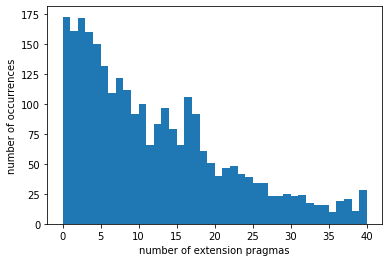

In [148]:
pl.hist(pkgs['extensionPragmas'].apply(len) + pkgs['defaultExtensions'].apply(len),
        range=(0, 40), bins=40)
pl.xlabel('number of extension pragmas')
pl.ylabel('number of occurrences')

In [149]:
usages = \
    [ (e, len([pkg for pkg in pkgs.itertuples() if e in pkg.defaultExtensions]),
          len([pkg for pkg in pkgs.itertuples() if e in pkg.extensionPragmas]))
      for e in allExtensions ]
usages = pd.DataFrame(usages, columns=['extension','default-extensions','pragmas'])
usages['total uses'] = usages['pragmas'] + usages['default-extensions']

In [150]:
usages.sort_values('total uses', ascending=False).style

,extension,default-extensions,pragmas,total uses
117,OverloadedStrings,495,1330,1825
88,ScopedTypeVariables,493,1169,1662
109,FlexibleInstances,414,1077,1491
31,FlexibleContexts,466,987,1453
28,CPP,111,1204,1315
70,TypeFamilies,379,829,1208
122,MultiParamTypeClasses,379,763,1142
134,LambdaCase,433,694,1127
102,DeriveGeneric,367,693,1060
13,GeneralizedNewtypeDeriving,327,708,1035


# GHC2021 impact

Let's see what fraction of packages use only the GHC2021 extensions.

In [151]:
ghc2021 = set('''
    BangPatterns
    BinaryLiterals
    ConstrainedClassMethods
    ConstraintKinds
    DeriveDataTypeable
    DeriveFoldable
    DeriveFunctor
    DeriveGeneric
    DeriveLift
    DeriveTraversable
    DoAndIfThenElse
    EmptyCase
    EmptyDataDecls
    EmptyDataDeriving
    ExistentialQuantification
    ExplicitForAll
    FieldSelectors
    FlexibleContexts
    FlexibleInstances
    ForeignFunctionInterface
    GADTSyntax
    GeneralisedNewtypeDeriving
    HexFloatLiterals
    ImplicitPrelude
    ImportQualifiedPost
    InstanceSigs
    KindSignatures
    MonomorphismRestriction
    MultiParamTypeClasses
    NamedFieldPuns
    NamedWildCards
    NumericUnderscores
    PatternGuards
    PolyKinds
    PostfixOperators
    RankNTypes
    RelaxedPolyRec
    ScopedTypeVariables
    StandaloneDeriving
    StandaloneKindSignatures
    StarIsType
    TraditionalRecordSyntax
    TupleSections
    TypeApplications
    TypeOperators
    TypeSynonymInstances
'''.split())

In [160]:
len(pkgs)

2858

In [159]:
n = len([
    pkg
    for pkg in pkgs.itertuples()
    if (pkg.defaultExtensions | pkg.extensionPragmas) < ghc2021
])
(n, n/len(pkgs))

(246, 0.086074177746676)

In [161]:
others = {
    'OverloadedStrings', 'TypeFamilies'
}    

n = len([
    pkg
    for pkg in pkgs.itertuples()
    if (pkg.defaultExtensions | pkg.extensionPragmas) < (ghc2021 | others)
])
(n, n/len(pkgs))

(362, 0.12666200139958012)

# Stability field

Over the entire history of Hackage:

In [125]:
!rg -iLuuu 'stability *: *(\w+)' --glob='*.hs' -o trees -r'$1' > stability
stability = pd.read_csv('stability', delimiter=':', names=['file','stability'])
pd.DataFrame(pd.value_counts(stability['stability'])).style

trees/hackport/hackport-0.5.1/hackport: No such file or directory (os error 2)
trees/hackport/hackport-0.5.2/hackport: No such file or directory (os error 2)
trees/hackport/hackport-0.5.3/hackport: No such file or directory (os error 2)
trees/caledon/caledon-3.2.1.0/examples/.#implicit.ncc: No such file or directory (os error 2)
trees/caledon/caledon-2.0.0.0/examples/.#universe.ncc: No such file or directory (os error 2)
trees/subnet/subnet-0.0.1/src/Network/.#Subnet.hs: No such file or directory (os error 2)
trees/rpc-framework/rpc-framework-2.0.0.1/.#README.md: No such file or directory (os error 2)
trees/rpc-framework/rpc-framework-2.0.0.1/src/.#RPCTest.hs: No such file or directory (os error 2)
trees/ipprint/ipprint-0.4/.#ipprint.cabal: No such file or directory (os error 2)


,stability
experimental,252863
auto,81156
provisional,57786
stable,37072
alpha,22063
unstable,20020
Provisional,11077
Experimental,8036
internal,3637
Stable,2739


Only most-recent version of each package:

In [126]:
!rg -iLuuu 'stability *: *(\w+)' --glob='*.hs' -o recent-trees -r'$1' > stability
stability = pd.read_csv('stability', delimiter=':', names=['file','stability'])
pd.DataFrame(pd.value_counts(stability['stability'])).style

,stability
experimental,16279
auto,9979
provisional,3739
stable,2223
unstable,1443
Experimental,749
alpha,546
Provisional,348
Stable,316
internal,191
